# Forward Error Correction Bit Error Analysis

In [1]:
from pynq import Overlay
import numpy as np
import xsdfec

from helper_functions import *

ol = Overlay('bitstream/ldpc_loopback.bit')

Adding LDPC code parameters to "ldpc_encoder/sd_fec" internal memory.

Status     Code ID    SC Offset  LA Offset  QC Offset  Code Name 
------     ------     ------     ------     ------     ------    
Loaded     0          0          0          0          docsis_short
Loaded     1          2          2          21         docsis_medium
Loaded     2          4          4          54         docsis_long
Loaded     3          6          6          97         docsis_init_ranging
Loaded     4          8          8          112        docsis_fine_ranging
Loaded     5          9          9          120        wifi802_11_cr1_2_648
Loaded     6          15         15         196        wifi802_11_cr1_2_1296
Loaded     7          21         21         240        wifi802_11_cr1_2_1944
Loaded     8          27         27         270        wifi802_11_cr2_3_648
Loaded     9          31         31         324        wifi802_11_cr2_3_1296
Loaded     10         35         35         360        wifi8

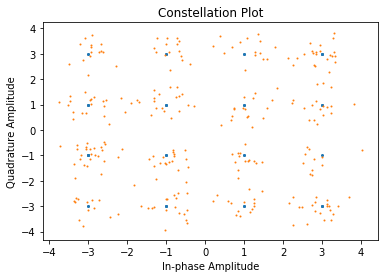

In [2]:
# Encode
e_fec = ol.ldpc_encoder.sd_fec
e_dma_data = ol.ldpc_encoder.axi_dma_data
e_dma_ctrl = ol.ldpc_encoder.axi_dma_ctrl

ldpc_params = e_fec.available_ldpc_params()
add_multiple_ldpc_params(e_fec, ldpc_params)

code_name = 'docsis_short'
code_id = ldpc_params.index(code_name)

e_tx_buffer = create_tx_buffer(e_fec, code_name, ldpc_params)
e_rx_buffer = create_rx_buffer(e_fec, code_name, ldpc_params)
e_ctrl_buffer = create_ctrl_buffer()
e_status_buffer = create_status_buffer()

for i in range(len(e_tx_buffer))[::4]:
    e_tx_buffer[i] = np.random.randint(1,255)

ctrl_params = {'id' : 0, 'code' : code_id}
set_ctrl_reg(e_dma_ctrl, e_ctrl_buffer, ctrl_params)
e_rx_buffer = transfer_data(e_dma_data, e_tx_buffer, e_rx_buffer)
e_status_buffer = get_status_reg(e_dma_ctrl, e_status_buffer)

check_encoding(e_fec, e_tx_buffer, e_rx_buffer, code_name, ldpc_params)

# Channel
SNR = 15
hard_binary = serialise_data(e_rx_buffer)
signal = modulate(hard_binary, plot=True)
signal_with_noise = add_noise(signal, SNR, plot=True)
llrs = soft_demodulate(signal_with_noise)
llrs_formatted = format_llrs(llrs)

# Decode
d_fec = ol.ldpc_decoder.sd_fec
d_dma_data = ol.ldpc_decoder.axi_dma_data
d_dma_ctrl = ol.ldpc_decoder.axi_dma_ctrl

ldpc_params = d_fec.available_ldpc_params()
add_multiple_ldpc_params(d_fec, ldpc_params)

code_id = ldpc_params.index(code_name)

d_tx_buffer = create_tx_buffer(d_fec, code_name, ldpc_params)
d_rx_buffer = create_rx_buffer(d_fec, code_name, ldpc_params)
d_ctrl_buffer = create_ctrl_buffer()
d_status_buffer = create_status_buffer()

j = 0
for i in range(len(d_tx_buffer))[::4]:
    d_tx_buffer[i] = llrs_formatted[j]
    j += 1
    
ctrl_params = {'id' : 0, 
               'max_iterations' : 24,
               'term_on_no_change' : 1,
               'term_on_pass' : 1, 
               'include_parity_op' : 0,
               'hard_op' : 1,
               'code' : code_id}
set_ctrl_reg(d_dma_ctrl, d_ctrl_buffer, ctrl_params)
d_rx_buffer = transfer_data(d_dma_data, d_tx_buffer, d_rx_buffer)
# d_status_buffer = get_status_reg(d_dma_ctrl, d_status_buffer)

In [3]:
# for i in range(len(e_tx_buffer[::4])):
#     print(e_tx_buffer[i*4], d_rx_buffer[i*4])
    
print((e_tx_buffer[::4] == d_rx_buffer[::4]).all())
print((e_tx_buffer[::4] == d_rx_buffer[::4]))

True
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
